In [10]:
using DelimitedFiles
using DataFrames
using DynamicAxisWarping
using Plots

push!(LOAD_PATH,"./src/")
using ExpEval

In [11]:
## For UCR archive information handeling
url="https://www.cs.ucr.edu/~eamonn/time_series_data_2018/DataSummary.csv"
DataSumary, DataSumary_header = readdlm(download(url), ',', header = true)
DataSumary_header[[1,4,5]] = ["ID", "Train", "Test"] # Original names "\ufeffID", "Train ", "Test "

DataSumary_df = DataFrame(DataSumary, vec(DataSumary_header))
println(size(DataSumary_df))
print(DataSumary_df[1:15,:])

(128, 12)
15×12 DataFrame
 Row │ ID   Type       Name                   Train  Test  Class  Length  ED (w=0)  DTW (learned_w)   DTW (w=100)  Default rate  Data donor/editor        
     │ Any  Any        Any                    Any    Any   Any    Any     Any       Any               Any          Any           Any                      
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 1    Image      Adiac                  390    391   37     176     0.3887    0.3913 (3)        0.3964       0.9591        A. Jalba
   2 │ 2    Image      ArrowHead              36     175   3      251     0.2       0.2000 (0)        0.2971       0.6057        L. Ye & E. Keogh
   3 │ 3    Spectro    Beef                   30     30    5      470     0.3333    0.3333 (0)        0.3667       0.8           K. Kemsley &  A. Bagnall
   4 │ 4    Image      BeetleFly              20     20    2      512  

In [12]:
## THIS SHOULD BE IN UTILS

function relabelLabels(labels_old)
    # Take a vector of n labels from c clases (works for ints and strings) 
    # and maps it bijectivelly to 1,2,...,c
    # Example: [b,b,a,c,b] -> [2,2,1,3,2]
    
    classes = sort(unique(labels_old))
    labels = Array{Int, 1}(undef, length(labels_old))
    
    for i = 1:length(labels_old)
        for j = 1:length(classes)
            if labels_old[i] == classes[j]
                labels[i] = j
            end
        end
    end
    return labels
end

relabelLabels (generic function with 1 method)

In [13]:
# Load test dataset 
ID = 101
TEST, TEST_labels, TRAIN, TRAIN_labels = LoadDataBase(ID, DataSumary_df, true);

#labels = relabelLabels()

ID      : 101
Name    : Fungi
Length  : 201
Train   : 18
Test    : 186
Classes : 18
    Train Classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
    Test  Classes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
---------------------------------------------------


In [14]:
function dtw_naive(x,y)
    I = length(x)
    J = length(y)
    
    δm = [(x[i] - y[j])^2 for i=1:I, j=1:J]
    C = Inf*ones(I+1, J+1)
    
    C[1,1] = 0

    φm = zeros(Int, I+1, J+1)
    φm[2:I+1,1] .= 2
    φm[1,2:J+1] .= 3
    
    
    for i = 2:I+1
        for j = 2:J+1
            C[i,j] = δm[i-1,j-1] + min([
                C[i-1, j-1]    
                C[i-1, j]
                C[i, j-1]                
            ]...)
            φm[i,j] = argmin([
                    C[i-1, j-1]
                    C[i-1, j]
                    C[i, j-1]
                    ])
            
            if i<=3 && j<=3
                println("\nnaive i=$i j=$j")
                display(C[1:4,1:4])
                display(φm[1:4,1:4])
            end
        end
    end
    
    i = I
    j = J
    πi = [i]
    πj = [j]
    while i>1 || j>1
        if φm[i+1,j+1] == 1
            i = i - 1
            j = j - 1
        elseif φm[i+1,j+1] == 2
            i = i - 1
        elseif φm[i+1,j+1] == 3
            j = j - 1
        else
            break
        end        
        append!(πi, max(i,1))
        append!(πj, max(j,1))
    end
    #display(δm)
    #display(C)
    #display(φm)
    
    return C[I+1,J+1], reverse!(πi), reverse!(πj)
end

dtw_naive (generic function with 1 method)

In [6]:
# wrong version
function dtw_arrow(x,y)
    I = length(x)
    J = length(y)
    
    δm = [(x[i] - y[j])^2 for i=1:I, j=1:J]
    C = zeros(I+1, J+1)
    
    φm = zeros(Int, I+1, J+1)
    φm[2:I+1,1] .= 2
    φm[1,2:J+1] .= 3
    
    for i = 2:I+1
        for j = 2:J+1
            if i>2
                ev = any(isnan.([x[i-1], x[i-2], y[j-1]])) ? Inf : 0
            else
                ev = any(isnan.([x[i-1], y[j-1]])) ? Inf : 0
            end
            if j>2
                eh = any(isnan.([x[i-1], y[j-1], y[j-2]])) ? Inf : 0
            else
                eh = any(isnan.([x[i-1], y[j-1]])) ? Inf : 0
            end
                
            C[i,j] = δm[i-1,j-1] + min([
                C[i-1, j-1]    
                C[i-1, j] + ev
                C[i, j-1] + eh               
            ]...)
            φm[i,j] = argmin([
                    C[i-1, j-1]
                    C[i-1, j] + ev
                    C[i, j-1] + eh
                    ])
        end
    end    
    
    i = I
    j = J
    πi = [i]
    πj = [j]
    while i>1 || j>1
        if φm[i+1,j+1] == 1
            i = i - 1
            j = j - 1
        elseif φm[i+1,j+1] == 2
            i = i - 1
        elseif φm[i+1,j+1] == 3
            j = j - 1
        else
            break
        end        
        append!(πi, max(i,1))
        append!(πj, max(j,1))
    end
    #display(δm)
    #display(C)
    #display(φm)
    
    
    Iav = length(filter(!isnan, x))
    Jav = length(filter(!isnan, y))
    γ = (I + J) / (Iav + Jav)
    
    return γ*C[I+1,J+1], reverse!(πi), reverse!(πj)
end

dtw_arrow (generic function with 1 method)

In [19]:
function dtw_arrow(x,y)
    I = length(x)
    J = length(y)
    
    δm = [(x[i] - y[j])^2 for i=1:I, j=1:J]
    C = zeros(I+1, J+1)
    
    φm = zeros(Int, I+1, J+1)
    φm[2:I+1,1] .= 2
    φm[1,2:J+1] .= 3
    
    for i = 2:I+1
        for j = 2:J+1
            if i>2
                ev = any(isnan.([x[i-1], x[i-2], y[j-1]])) ? Inf : 0
            else
                ev = Inf
            end
            if j>2
                eh = any(isnan.([x[i-1], y[j-1], y[j-2]])) ? Inf : 0
            else
                eh = Inf
            end
                
            C[i,j] = δm[i-1,j-1] + min([
                C[i-1, j-1]    
                C[i-1, j] + ev
                C[i, j-1] + eh               
            ]...)
            φm[i,j] = argmin([
                    C[i-1, j-1]
                    C[i-1, j] + ev
                    C[i, j-1] + eh
                    ])
            
            if i<=3 && j<=3
                println("\narrow i=$i j=$j")
                display(C[1:4,1:4])
                display(φm[1:4,1:4])
            end
        end
    end    
    
    i = I
    j = J
    πi = [i]
    πj = [j]
    while i>1 || j>1
        if φm[i+1,j+1] == 1
            i = i - 1
            j = j - 1
        elseif φm[i+1,j+1] == 2
            i = i - 1
        elseif φm[i+1,j+1] == 3
            j = j - 1
        else
            break
        end        
        append!(πi, max(i,1))
        append!(πj, max(j,1))
        
        if i<=3 || j<=3
            println("arrowpath ij = $i $j")

        end
    end
    #display(δm)
    #display(C)
    #display(φm)
    
    
    Iav = length(filter(!isnan, x))
    Jav = length(filter(!isnan, y))
    γ = (I + J) / (Iav + Jav)
    
    return γ*C[I+1,J+1], reverse!(πi), reverse!(πj)
end

dtw_arrow (generic function with 1 method)

C_3 = 1
C_5 = 1

naive i=2 j=2


4×4 Matrix{Float64}:
  0.0  Inf           Inf  Inf
 Inf    0.000117096  Inf  Inf
 Inf   Inf           Inf  Inf
 Inf   Inf           Inf  Inf

4×4 Matrix{Int64}:
 0  3  3  3
 2  1  0  0
 2  0  0  0
 2  0  0  0


naive i=2 j=3


4×4 Matrix{Float64}:
  0.0  Inf           Inf         Inf
 Inf    0.000117096   0.0031162  Inf
 Inf   Inf           Inf         Inf
 Inf   Inf           Inf         Inf

4×4 Matrix{Int64}:
 0  3  3  3
 2  1  3  0
 2  0  0  0
 2  0  0  0


naive i=3 j=2


4×4 Matrix{Float64}:
  0.0  Inf           Inf         Inf
 Inf    0.000117096   0.0031162   0.00976055
 Inf    0.00493067   Inf         Inf
 Inf   Inf           Inf         Inf

4×4 Matrix{Int64}:
 0  3  3  3
 2  1  3  3
 2  2  0  0
 2  0  0  0


naive i=3 j=3


4×4 Matrix{Float64}:
  0.0  Inf           Inf         Inf
 Inf    0.000117096   0.0031162   0.00976055
 Inf    0.00493067    0.0129592  Inf
 Inf   Inf           Inf         Inf

4×4 Matrix{Int64}:
 0  3  3  3
 2  1  3  3
 2  2  1  0
 2  0  0  0


arrow i=2 j=2


4×4 Matrix{Float64}:
 0.0  0.0          0.0  0.0
 0.0  0.000117096  0.0  0.0
 0.0  0.0          0.0  0.0
 0.0  0.0          0.0  0.0

4×4 Matrix{Int64}:
 0  3  3  3
 2  1  0  0
 2  0  0  0
 2  0  0  0


arrow i=2 j=3


4×4 Matrix{Float64}:
 0.0  0.0          0.0        0.0
 0.0  0.000117096  0.0029991  0.0
 0.0  0.0          0.0        0.0
 0.0  0.0          0.0        0.0

4×4 Matrix{Int64}:
 0  3  3  3
 2  1  1  0
 2  0  0  0
 2  0  0  0


arrow i=3 j=2


4×4 Matrix{Float64}:
 0.0  0.0          0.0        0.0
 0.0  0.000117096  0.0029991  0.00664435
 0.0  0.00481357   0.0        0.0
 0.0  0.0          0.0        0.0

4×4 Matrix{Int64}:
 0  3  3  3
 2  1  1  1
 2  1  0  0
 2  0  0  0


arrow i=3 j=3


4×4 Matrix{Float64}:
 0.0  0.0          0.0        0.0
 0.0  0.000117096  0.0029991  0.00664435
 0.0  0.00481357   0.0129592  0.0
 0.0  0.0          0.0        0.0

4×4 Matrix{Int64}:
 0  3  3  3
 2  1  1  1
 2  1  1  0
 2  0  0  0

arrowpath ij = 3 32
arrowpath ij = 2 32
arrowpath ij = 1 32
arrowpath ij = 0 31
arrowpath ij = 0 30
arrowpath ij = 0 29
arrowpath ij = 0 28
arrowpath ij = 0 27
arrowpath ij = 0 26
arrowpath ij = 0 25
arrowpath ij = 0 24
arrowpath ij = 0 23
arrowpath ij = 0 22
arrowpath ij = 0 21
arrowpath ij = 0 20
arrowpath ij = 0 19
arrowpath ij = 0 18
arrowpath ij = 0 17
arrowpath ij = 0 16
arrowpath ij = 0 15
arrowpath ij = 0 14
arrowpath ij = 0 13
arrowpath ij = 0 12
arrowpath ij = 0 11
arrowpath ij = 0 10
arrowpath ij = 0 9
arrowpath ij = 0 8
arrowpath ij = 0 7
arrowpath ij = 0 6
arrowpath ij = 0 5
arrowpath ij = 0 4
arrowpath ij = 0 3
arrowpath ij = 0 2
arrowpath ij = 0 1
dtw1 = 57.68670766729033
dtw2 = 57.68670766729033
dtw3 = 57.23895101115708


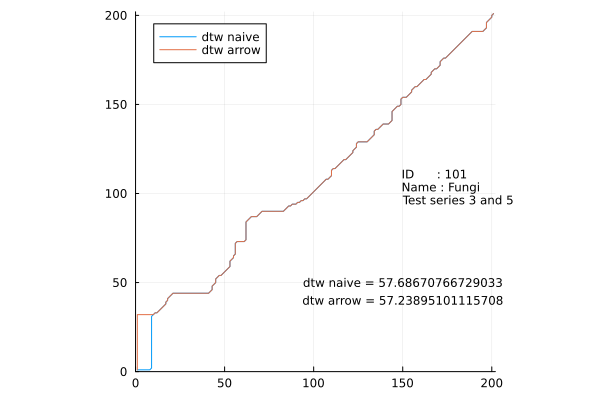

In [20]:
a = 3
b = 5

A = TEST[a,:]
B = TEST[b,:]

println("C_$a = ",TEST_labels[a],"\nC_$b = ",TEST_labels[b])


dtw1, i1, j1  = dtw(A, B)
dtw2, i2, j2  = dtw_naive(A, B)
dtw3, i3, j3  = dtw_arrow(A, B)

println("dtw1 = $dtw1\ndtw2 = $dtw2\ndtw3 = $dtw3")

#plot(i1, j1, ratio=1)
fig = plot()
plot!(i2, j2, ratio=1, label="dtw naive")
plot!(i3, j3, ratio=1, label="dtw arrow")
z = 202
xlims!(0,z)
ylims!(0,z)

annotate!(150, 100, ("ID      : 101\nName : Fungi\nTest series $a and $b\n", :left, 8))
annotate!(150, 50, ("dtw naive = $dtw2", 8))
annotate!(150, 40, ("dtw arrow = $dtw3", 8))

In [14]:
display([[i1[k],j1[k]] for k =1:4])
display([[i2[k],j2[k]] for k =1:4])
display([[i3[k],j3[k]] for k =1:4])

4-element Vector{Vector{Int64}}:
 [1, 1]
 [2, 1]
 [3, 1]
 [4, 1]

4-element Vector{Vector{Int64}}:
 [1, 1]
 [2, 1]
 [3, 1]
 [4, 1]

4-element Vector{Vector{Int64}}:
 [1, 1]
 [1, 2]
 [1, 3]
 [1, 4]

In [2]:
i=0
j=3
(i>0)&&(j>0)

false